# EDA

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [2]:
raw_data = "../raw/train.csv"
sub_data = "../raw/sample_submission.csv"
test_data = "../raw/test/{}.csv" 
proc_data = "../processed/{}"

In [81]:
df = pd.read_csv(raw_data, header=0, nrows=5656574)
df.columns = ["x", "y"]

In [90]:
features = dict(
        x=["std", "mean"]
    )
df1 = df.iloc[4400000: 4400000 + 150000].groupby(lambda x: x // 10000, as_index=False).agg(features).stack()
df1.index = df1.index.map(lambda x: f"{x[1]}_{x[0]}")
# df1.index = df1.index.map("_".join)
df1

,x
std_0,6.649567
mean_0,4.693600
std_1,8.027838
mean_1,4.618600
std_2,3.738326
mean_2,4.489100
std_3,511.408635
mean_3,4.021100
std_4,140.060612
mean_4,4.597000


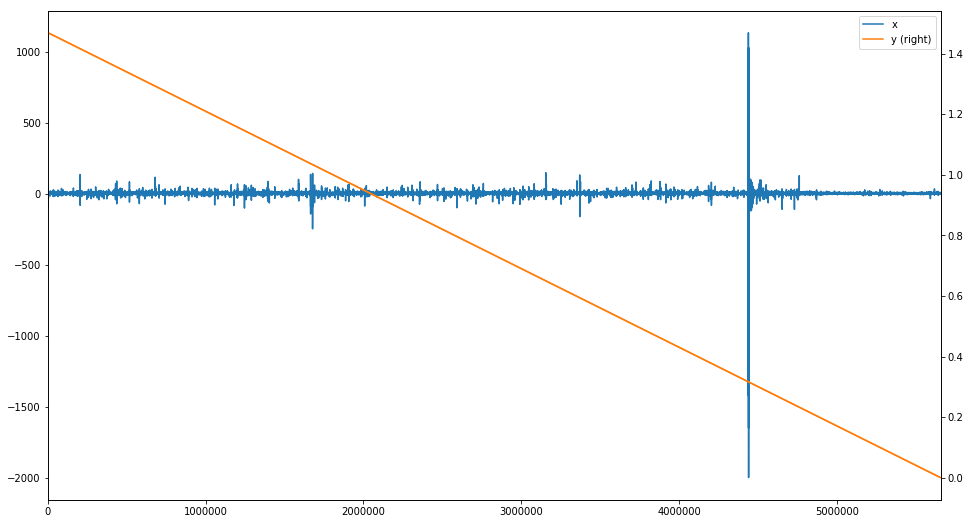

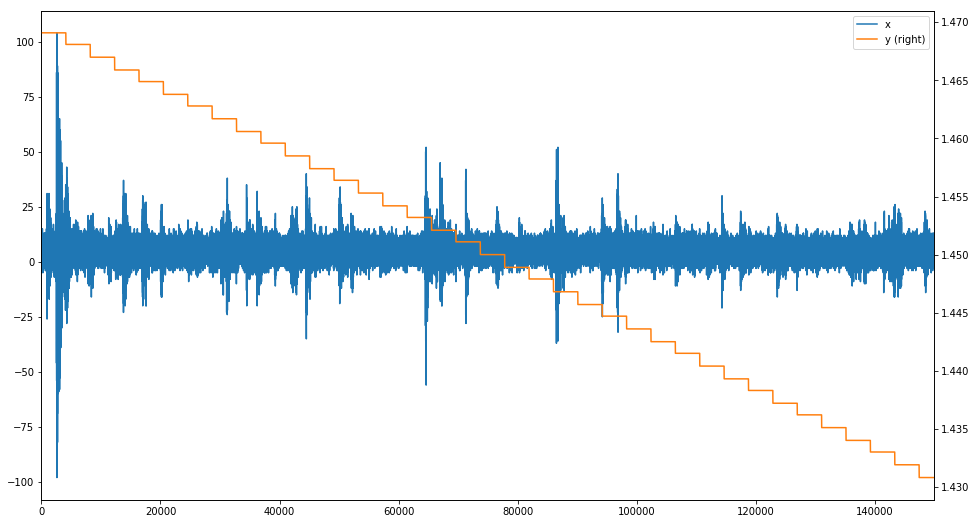

In [68]:
df.loc[::100,:].plot(figsize=(16,9), secondary_y=["y"])
a = 4400000
df.loc[a:a + 150000].plot(figsize=(16,9), secondary_y=["y"])

In [49]:
df.tail()

,x,y
5656569,0,0.000795
5656570,2,0.000795
5656571,4,0.000795
5656572,5,0.000795
5656573,4,0.000795


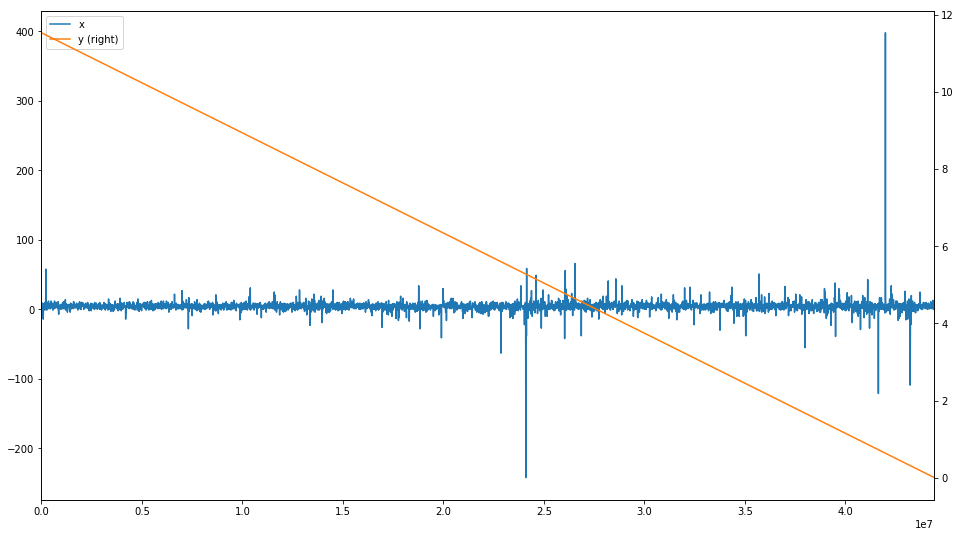

In [59]:
df = pd.read_csv(raw_data, skiprows=5656574, nrows=44429303)
df.columns = ["x", "y"]
df.loc[::10000,:].plot(figsize=(16,9), secondary_y=["y"])

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44429303 entries, 0 to 44429302
Data columns (total 2 columns):
x    int64
y    float64
dtypes: float64(1), int64(1)
memory usage: 677.9 MB


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44429303 entries, 0 to 44429302
Data columns (total 2 columns):
x    int32
y    float64
dtypes: float64(1), int32(1)
memory usage: 508.5 MB


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44429303 entries, 0 to 44429302
Data columns (total 2 columns):
x    int32
y    float32
dtypes: float32(1), int32(1)
memory usage: 339.0 MB


In [65]:
df.y = df.y.astype('float32')

In [70]:
df.x.describe()

count    4.442930e+07
mean     4.507813e+00
std      1.090078e+01
min     -3.301000e+03
25%      2.000000e+00
50%      5.000000e+00
75%      7.000000e+00
max      3.914000e+03
Name: x, dtype: float64

In [102]:
summary = []
for name in tqdm_notebook(pd.read_csv(sub_data).seg_id):
    summary.append(pd.read_csv(test_data.format(name)).describe())

In [82]:
len(summary)

2624

In [84]:
df_sum = pd.concat(summary, axis=1)

In [120]:
df_sum.T.describe()

,count,mean,std,min,25%,50%,75%,max
count,2624.0,2624.000000,2624.000000,2624.000000,2624.000000,2624.000000,2624.000000,2624.000000
mean,150000.0,4.148616,6.684161,-154.099848,1.804402,4.075457,6.488948,165.683689
std,0.0,0.252326,8.744635,291.376009,0.488788,0.280963,0.550770,276.517022
min,150000.0,3.410040,2.848341,-6323.000000,-2.000000,3.000000,5.000000,28.000000
25%,150000.0,3.974123,4.640139,-162.000000,2.000000,4.000000,6.000000,93.000000
50%,150000.0,4.148043,5.816308,-117.000000,2.000000,4.000000,6.000000,128.000000
75%,150000.0,4.328440,7.055588,-81.000000,2.000000,4.000000,7.000000,172.000000
max,150000.0,4.940780,171.321744,-20.000000,3.000000,5.000000,11.000000,6741.000000


In [53]:
def yield_train_blocks(chunksize=150000):
    yield from pd.read_csv(
        raw_data, 
        names=["x", "y"], 
        dtype={"x": "int32", "y": "float32"}, 
        skiprows=1, 
        chunksize=chunksize
    )

In [27]:
def yield_sub_series():
    min_y = None
    blocks = []
    for block in yield_train_blocks():
        blocks.append(block)
        block_min_time = block.y.min()
        if min_y is None or block_min_time < min_y:
            min_y = block_min_time
            continue
        df = pd.concat(blocks, ignore_index=True)
        end_of_series = df.y.idxmin()
        blocks = [df.loc[end_of_series+1:]]
        min_y = blocks[0].y.min()
        yield df.loc[:end_of_series]
    yield pd.concat(blocks, ignore_index=True)

In [28]:
def save_series():
    for num, df in tqdm_notebook(enumerate(yield_sub_series()), total=17):
        df.to_pickle(proc_data.format(f"data{num}.pickle"))

In [29]:
save_series()

In [14]:
q = 0
for df in tqdm_notebook(yield_train_blocks()):
    q += len(df)
print(q)    


629145480


In [52]:
629145480 // 150000 - 17

4177

In [31]:
pd.read_pickle(proc_data.format(f"data7.pickle")).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62009332 entries, 0 to 62009331
Data columns (total 2 columns):
x    int32
y    float32
dtypes: float32(1), int32(1)
memory usage: 473.1 MB


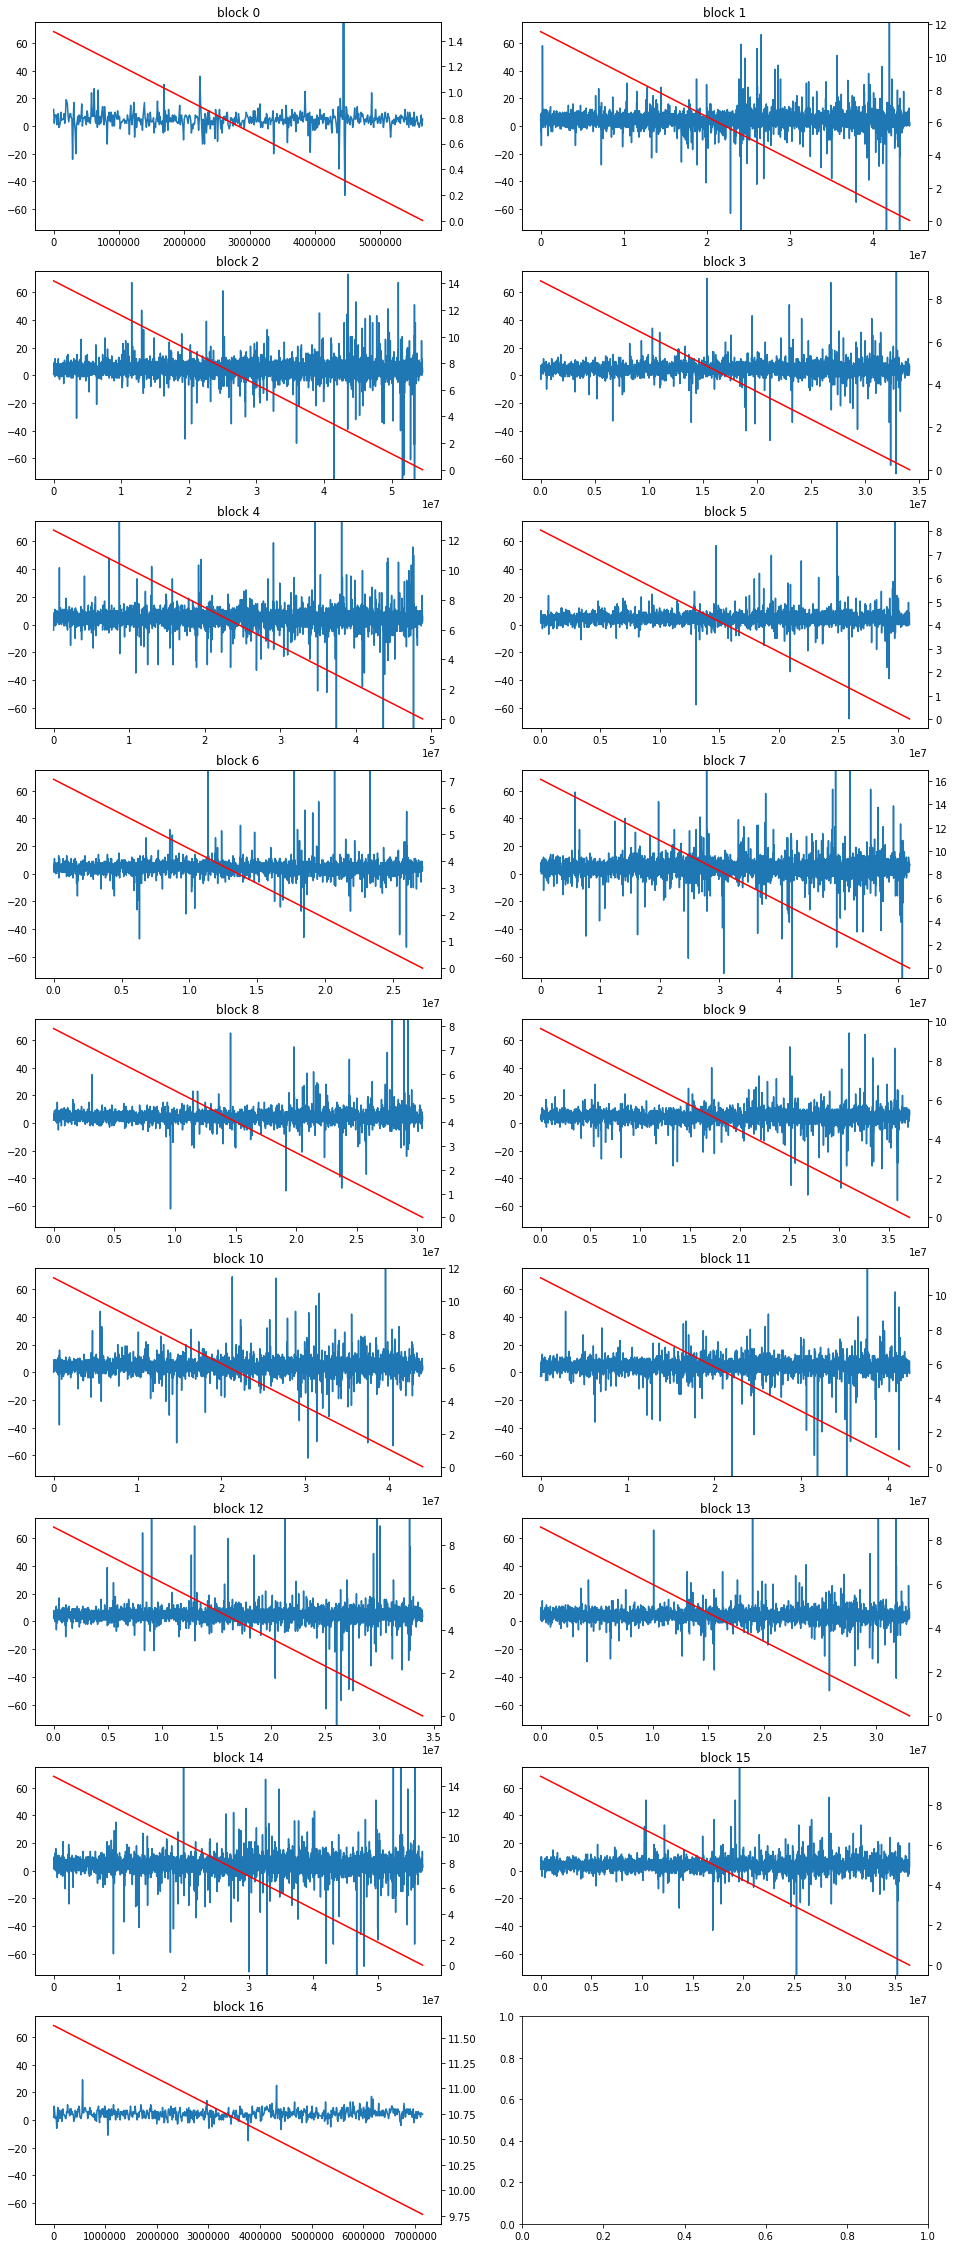

In [50]:
_, axs = plt.subplots(9, 2, figsize=(16, 9 * 9 / 2))
axs = axs.flatten()
for i in tqdm_notebook(range(17)):
    df = pd.read_pickle(proc_data.format(f"data{i}.pickle"))
    axs[i].set_title(f"block {i}") 
    ax2 = axs[i].twinx()
    axs[i].set_ylim(-75, 75)
    axs[i].plot(df.x.loc[::10000])   
    ax2.plot(df.y.loc[::10000], color='r')   